In [1]:
import gym

import random
from collections import defaultdict
import numpy as np

import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MaxNLocator
from functools import partial
%matplotlib inline

matplotlib.style.use('ggplot')

In [2]:
# start a new blackjack env
env = gym.make('Blackjack-v1')

In [3]:
def get_action(Q, state, epsilon):
    random_action = random.randint(0, 1)
    best_action = np.argmax(Q[state])
    return np.random.choice([best_action, random_action], p=[1 - epsilon, epsilon]) 

In [4]:
def evaluate_policy(Q, evaluating_episodes):
    wins = 0
    for _ in range(evaluating_episodes):
        state = env.reset()[0]
        
        done = False
        while not done:
            action = np.argmax(Q[state])
            
            state, reward, done, _ = env.step(action=action)[:-1]
            
        if reward > 0:
            wins += 1
        
    return wins / evaluating_episodes

In [5]:
def get_glie_epsilon(episodes):
    # return 1/episodes
    if episodes == 0:
        epsilon = 0
    else:
        eps_start=1.0 
        eps_decay=0.99999
        eps_min=0

        epsilon = eps_start*(eps_decay**(episodes-1))

    return epsilon

In [6]:
# constant alpha
def sarsamax(env, episodes, alpha, gamma, evaluating_episodes):

    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # value function
    policy = defaultdict(lambda: np.zeros(env.action_space.n)) 

    state_count = defaultdict(float) # state
    
    evaluations = [] # keeping track of our policy evaluations
    evaluate = False
    
    for i in range(episodes):
        # evaluating a policy every 1000 games
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q, evaluating_episodes))
            print(f'at {i}')
    
        episode = [] # record states and actions to update value function
        
        # Game starting
        now_state = env.reset()[0]
        done = False
        now_action = get_action(Q, now_state, get_glie_epsilon(i+1)) if now_state in Q else env.action_space.sample()
        
        # generating episodes
        while not done:
            state_count[now_state] += 1
            policy[now_state] = now_action
            
            next_state, reward, done, _ = env.step(action=now_action)[:-1]
            next_action = get_action(Q, now_state, get_glie_epsilon(i+2)) if now_state in Q else env.action_space.sample()
            
            episode.append((now_state, now_action, reward))
            
            delta = reward + gamma * max(Q[next_state]) - Q[now_state][now_action]
            Q[now_state][now_action] = Q[now_state][now_action] + alpha * delta
            
            # for next state
            now_state = next_state
            now_action = next_action

        
        evaluate = True
        # print(Q[s])
            
    return Q, evaluations, policy

In [7]:
q, evaluations, policy = sarsamax(env, 1000000, 0.001, 0.4, 10000)

at 1000
at 2000
at 3000
at 4000
at 5000
at 6000
at 7000
at 8000
at 9000
at 10000
at 11000
at 12000
at 13000
at 14000
at 15000
at 16000
at 17000
at 18000
at 19000
at 20000
at 21000
at 22000
at 23000
at 24000
at 25000
at 26000
at 27000
at 28000
at 29000
at 30000
at 31000
at 32000
at 33000
at 34000
at 35000
at 36000
at 37000
at 38000
at 39000
at 40000
at 41000
at 42000
at 43000
at 44000
at 45000
at 46000
at 47000
at 48000
at 49000
at 50000
at 51000
at 52000
at 53000
at 54000
at 55000
at 56000
at 57000
at 58000
at 59000
at 60000
at 61000
at 62000
at 63000
at 64000
at 65000
at 66000
at 67000
at 68000
at 69000
at 70000
at 71000
at 72000
at 73000
at 74000
at 75000
at 76000
at 77000
at 78000
at 79000
at 80000
at 81000
at 82000
at 83000
at 84000
at 85000
at 86000
at 87000
at 88000
at 89000
at 90000
at 91000
at 92000
at 93000
at 94000
at 95000
at 96000
at 97000
at 98000
at 99000
at 100000
at 101000
at 102000
at 103000
at 104000
at 105000
at 106000
at 107000
at 108000
at 109000
at 110000
at 11100

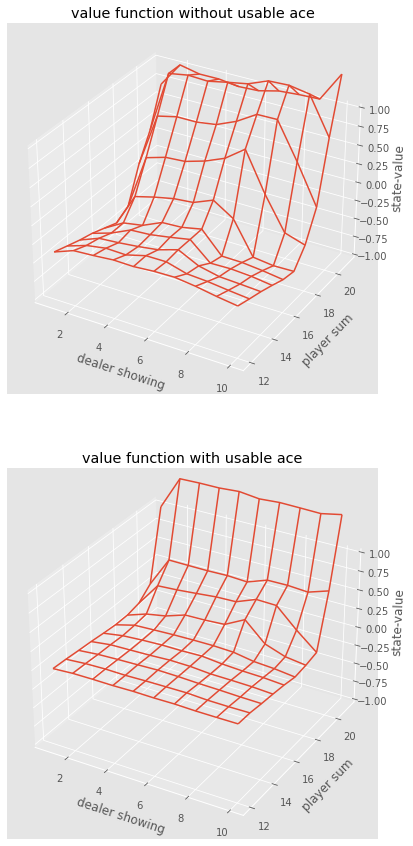

<Figure size 1800x1440 with 0 Axes>

In [13]:
def plot_value_function(q, ax1, ax2):
    plt.figure(figsize=(25,20))
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    # player_sum = np.arange(1, 10 + 1)
    # dealer_show = np.arange(12, 21 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = max(q[player, dealer, ace])
    
    X, Y = np.meshgrid(dealer_show, player_sum)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        
fig, axes = pyplot.subplots(nrows=2, figsize=(20, 15), subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_value_function(q, axes[0], axes[1])

Text(0, 0.5, 'win rate')

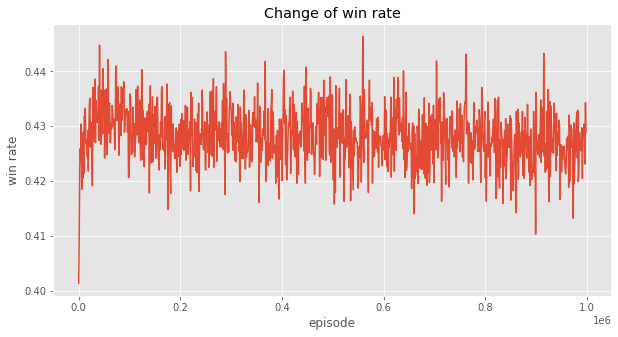

In [9]:
plt.figure(figsize=(10,5))
plt.plot([i * 1000 for i in range(len(evaluations))], evaluations)
plt.title('Change of win rate')
plt.xlabel('episode')
plt.ylabel('win rate')

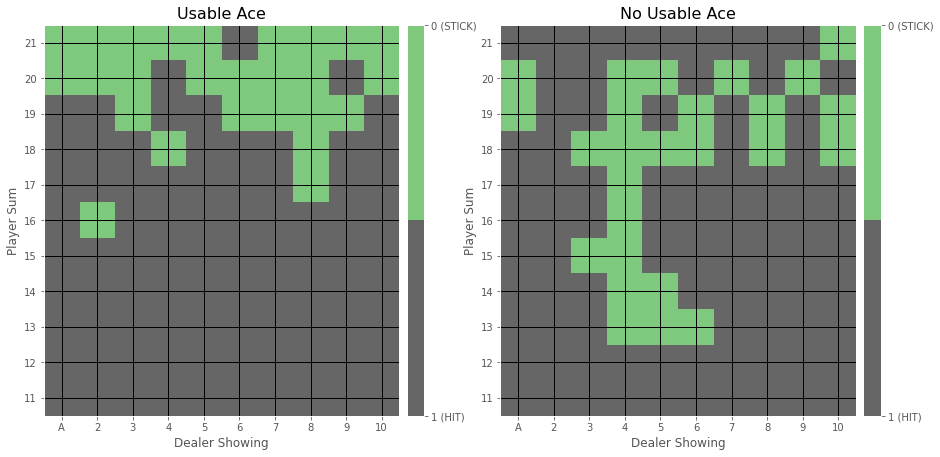

In [10]:
def get_Z(player_hand, dealer_showing, usable_ace, policy):
    if (player_hand, dealer_showing, usable_ace) in policy:
        return policy[player_hand, dealer_showing, usable_ace]
    else:
        return 1

def get_figure(usable_ace, ax, policy):
    x_range = np.arange(1, 11)
    y_range = np.arange(11, 22)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace, policy) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
    plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
    plt.yticks(y_range)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.grid(color='black', linestyle='-', linewidth=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
    cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
    cbar.ax.invert_yaxis()     
    
def plot_policy(policy):           
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax, policy)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax, policy)
    plt.show()

p = dict((s,np.max(v)) for s, v in policy.items())
plot_policy(p)